# 2.3 多因子选股策略
本文使用的模型是一个比较简单的多因子选股策略，使用的数据是收益率roe和市值market_cap，给这两个数据归一化以后，使用因子/建立的得分模型是得分=roe-market_cap，然后类似于小市值模型，多次筛选得分最高的n=20只股票调仓。

In [ ]:
def initialize(context):
    set_benchmark('000300.XSHG')
    set_option('use_real_price', True)
    set_order_cost(OrderCost(open_tax=0, close_tax=0.001, open_commission=0.0003,\
                             close_commission=0.0003, close_today_commission=0, min_commission=5),type='stock')
    
    g.security = get_index_stocks('000300.XSHG')
   
    g.q = query(valuation, indicator).filter(valuation.code.in_(g.security))
    g.N = 20 # 选市值最小的20只股票
 
    run_monthly(handle,1) # 自带的每月运行一次的函数
    
def handle(context):
    # 需要查询财务数据,market_cap和roe
    df = get_fundamentals(g.q)[['code','market_cap','roe']]
    # 归一化处理
    df['market_cap'] = (df['market_cap']- df['market_cap'].min())/(df['market_cap'].max() - df['market_cap'].min())
    df['roe'] = (df['roe']- df['roe'].min())/(df['roe'].max() - df['roe'].min())
    # 创建一个得分模型，得分=roe-market_cap
    df['score'] = df['roe'] - df['market_cap']
    
    df = df.sort_values('score').iloc[-g.N:,:]
    
    to_hold = df['code'].values
    
    for stock in context.portfolio.positions:
        if stock not in to_hold:
            order_target(stock,0)
    
    to_buy = [stock for stock in to_hold if stock not in context.portfolio.positions]
    
    if len(to_buy)>0:
        cash_per_stock = context.portfolio.available_cash / len(to_buy)
        for stock in to_buy:
            order_value(stock, cash_per_stock)    


In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams["font.sans-serif"] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

import numpy as np
import pandas as pd
data = pd.read_csv('/data/量化交易策略回测结果/2.3多因子选股策略.csv',encoding = 'ansi')
data.head()

,时间,基准收益,策略收益,当日盈利,当日亏损,当日买入,当日卖出,超额收益(%)
0,2020-01-02 16:00:00,1.36,0.50,497.0,0.0,53223,0.0,-0.85
1,2020-01-03 16:00:00,1.18,0.50,0.0,0.0,0,0.0,-0.67
2,2020-01-06 16:00:00,0.80,0.70,205.0,0.0,0,0.0,-0.10
3,2020-01-07 16:00:00,1.55,1.57,872.0,0.0,0,0.0,0.02
4,2020-01-08 16:00:00,0.38,0.89,0.0,-683.0,0,0.0,0.51


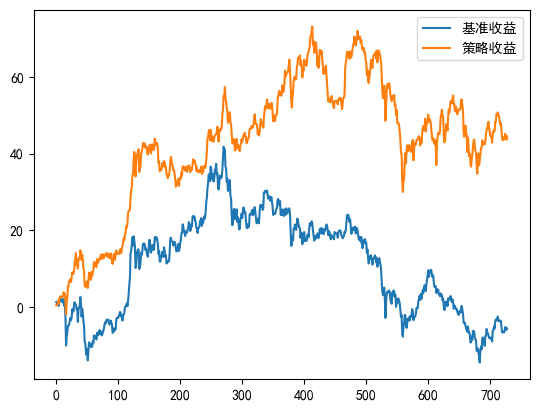

In [3]:
data[['基准收益', '策略收益']].plot()
plt.show()